# Thompson Sampling
Example solution if we were to go to a manual bidding regime where we send Google cost per clicks (CPCs)

Confluence with DoD concerns: https://conf.build.easyjet.com/pages/viewpage.action?pageId=409049383

This is a simulation example for CPCs of [0.3, 0.4, 0.5, 0.6, 0.7]. We set the true profit mean and widths to 

```
profit_true_values = [60, 100, 80, 120, 110]
profit_variance = [20,15,30,10,46]

```

These numbers were not chosen cleverly, although they are not far away from what we see in data.

If one wishes to move from a simulation to using real data, they would have to update the `profit` function in `UnknownMeanUnknownVariance`. This would simply grab the observed profit for the day (or however we aggregate).

The second part of the notebook explores what would happen if the true profit distribution drifts over time. 

# Using Conjugate Priors to Create Probability Models

When selecting an action, from a set of possible actions, Thompson Sampling takes a Bayesian approach. In our CPC problem, we maintain a model of the probability distribution of each cpc's actual output. Then, when we want to decide which cpc to try, we randomly choose a value from each of these models and select the cpc with the highest returned value (profit).

Obviously, before we have tried any of the cpcs, our initial estimate of the true output could be well off the mark. However, as we start collecting data by using the cpcs, we can begin to refine our estimate and gradually build up an increasingly accurate model of the true output.

In Bayesian terms our initial estimate is known as the <i>prior probability</i> and, after seeing some data and refining this estimate, we form the <i>posterior probability</i>. When both the prior and posterior have the same type of probability distribution they are said to be conjugate distributions. Additionally, when this happens, the prior is said to be the <i>conjugate prior</i> of the likelihood distribution (which can be thought of as the actual distribution of the data).

When the likelihood probability distribution has one of the more common distributions then the type of its conjugate prior can be found in the __[table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)__ on Wikipedia. Additionally, for each type of conjugate prior, this table specifies a set of hyper-parameters that can be updated, after seeing some data, to move from the prior to the posterior. In this way the probability model becomes more accurate, letting us make a more informed choice as to the best action to take.

There are many scenarios, etc:

* The variance is known, but the mean is unknown.
* The mean is known, but the variance is unknown.
* Both the mean and variance are unknown.

In the case of PPC Max Profit, we expect the mean and variance of the profit distributions to change as customer behaviour and competitor bids change. We therefore assume that we do not know the mean or variance of profit given a CPC. 

# Considering multiple bandits (campaigns)

In the case for PPC Max Profit, we have a large number of campaigns. We would need to do the following work for each campaign separately. This assumes that we do not see any impact from one campaign to another. To mitigate this, we could try unsupervised clustering techniques on our campaigns. 

Another potential issue that arises is the issue of total budget. easyJet will have a total budget they are willing to spend on ads. Treating each campaign or campaign group separately will make it hard to keep track of the total ad spend. This is partly because we do not know the exact expected number of clicks for a given campaign (and a given CPC). One solution is to forecast the number of clicks for a given campaign based on previous observations. Then run the Thompson Sampling on all campaigns and calculate the total amount spent. If this value is under or equal to the budget, continue. Otherwise, we can either re-run until this is not the case (re-run until a lower CPC is chosen), or select a campaign where a CPC was chosen that has a low confidence. i.e a high variance. Then, resample this one. Then work up the chain of least confident to most confident until the budget is satisfied. 

# List of potential speed bumps

1. Keeping below total budget or optimising this budget
2. If our initial guess is too low/high, after a few observations it might become almost impossible to choose a CPC option.
3. Can we handle negative observations in this framework? Answer is yes, but our chances of choosing it dwindles! A solution to this would be to do a hard reset on the expected distributions.

# Conclusions from this notebook

1. Thompson sampling is very easy to implement and is efficient when you don't have much data
2. If the true profit distribution drifts, it will take a relatively long time to recognise this
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
norm = stats.norm
gamma = stats.gamma
import scipy

# matplotlib setup
figsize(11.0, 10)

In [2]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
    """ a random tie-breaking argmax"""
    values = np.asarray(value_list)
    return np.argmax(np.random.random(values.shape) * (values==values.max()))

### Plotting scripts

In [3]:
def plot_pdf( trials, mean, variance, label, ymax = 0, set_height=False ):

    y = norm.pdf( x, mean, np.sqrt(variance) )

    p = plt.plot(x, y, lw=2, label = label )
    c = p[0].get_markeredgecolor()    
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(mean, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    
    if ymax == 0: ymax = y[1:].max()*1.1     
    
    if set_height:
        axes = plt.gca()
        axes.set_ylim([0,ymax])   
  
    return ymax


def plot_gamma( trials, alpha, beta, label, ymax = 0, precision = 0 ):

    variance = beta / (alpha + 1)

    y = stats.gamma.pdf(x, a=alpha, scale=1/beta)

    p = plt.plot(x, y, lw=2, label = f"var = {alpha/beta**2:.3f}" )
    c = p[0].get_markeredgecolor()  

    plt.fill_between(x, y, 0, color=c, alpha=0.2 )
  
    # if supplied, show the true precision
    if precision > 0:
        plt.vlines(x=[precision], ymin=0, ymax=(y[1:].max()*1.1), colors = c, linestyles = "--", lw = 2)
    
    plt.title(f"{trials} Trials - Mean Precision = {1/variance:.2f}")
    plt.legend() 
    plt.autoscale(tight=True)

    axes = plt.gca()
    axes.set_ylim([0,y[1:].max()*1.1]) 

norm = stats.norm
x = np.linspace(0.0,200.0,200)

def plot_cpc_pdfs(cpcs): 
  
    ymax = 0    
    for index, cpc in enumerate(cpcs):

        # get the PDF of the cpc using its true values
        y = norm.pdf( x, cpc.mu, np.sqrt(cpc.variance))

        p = plt.plot(x, y, lw=2, label = f"{0.3 + 0.1*index:.2f}" )
        c = p[0].get_markeredgecolor()    
        plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
        plt.legend()
        plt.autoscale(tight=True)

        plt.vlines(cpc.mu, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )

    axes = plt.gca()
    axes.set_ylim([0,ymax])          

    plt.legend(title = 'CPC Profit')
    plt.title('Density Plot of CPC profit')
    plt.xlabel('Profit Output [£]')
    plt.ylabel('Density')   
  
  
def plot_cpc(cpc, ymax = 0, title = None ):
    ymax1 = plot_pdf( cpc.n, cpc.mu, cpc.variance, "True", ymax )  
    ymax2 = plot_pdf( cpc.n, cpc.mu_0, cpc.variance_0, "Estimated", ymax )  

    if title is None: title = f"{cpc.n} Trials"        
    plt.title(title)

    # if no vertical extent is set automatically add space at top
    # - chooses the max from the 2 plots and adds 5%
    if ymax == 0: ymax = max(ymax1,ymax2)*1.05  
    axes = plt.gca()
    axes.set_ylim([0,ymax])    

def plot_cpcs(cpcs, cpc_probabilities ):
    
    trials = sum([cpc.n for cpc in cpcs])           
    plt.title(f"{trials} Trials")    

    ymax = 0    
    for index, cpc in enumerate(cpcs):

        # get the PDF of the socket using its estimates
        y = norm.pdf( x, cpc.mu_0, np.sqrt(cpc.variance_0) )

        p = plt.plot(x, y, lw=2, label = f'{0.3 + 0.1*index:.2f}:{cpc.n}/{trials}')
        c = p[0].get_markeredgecolor()    
        plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
        plt.legend()
        plt.autoscale(tight=True)

        plt.vlines(cpc.mu_0, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )

    axes = plt.gca()
    axes.set_ylim([0,ymax])    

### We do not know the mean or variance of profit for each CPC

In [35]:
class UnknownMeanUnknownVariance:
  
    def __init__(self, mu, variance):       
        self.mu = mu   # the true mean 
        self.variance = variance   # the true variance

        self.n = 0   # the number of times this CPC has been tried
        self.x = []  # list of all samples

        self.alpha = 1   # gamma shape parameter  
        self.beta = 100  # gamma rate parameter  

        self.mu_0 = 50 # the prior (estimated) mean. We expect £100 profit (not far off what we see)
        self.variance_0 = 10000#self.beta / (self.alpha + 1) # the prior (estimated) variance             
                    
    def update(self,x, idle_counts = 1):        
        ''' increase the number of times this CPC has been used and improve the estimate of the 
          mean and variance by combining the single new value 'x' with the current estimate '''
        n = 1
        v = self.n

        self.alpha = self.alpha + n/2     
        self.beta = self.beta + ((n*v/(v + n)) * (((x - self.mu_0)**2)/2))

        # estimate the variance - calculate the mean from the gamma hyper-parameters
        self.variance_0 = (self.beta / (self.alpha + 1)) * idle_counts      

        self.x.append(x)  # append the new value to the list of samples 
        self.n += 1
        self.mu_0 = np.array(self.x).mean()          
        
    def profit(self):
        ''' return a value using the true mean and variance for the socket 
            this function would grab the profit observed in the day
        '''              
        value = np.random.normal( self.mu, np.sqrt(self.variance) )

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value      
    
    def sample(self, idle_counts=1):  
        ''' sample from our estimated normal '''                   

        precision = np.random.gamma(self.alpha, 1/self.beta)
        if precision == 0 or self.n == 0: precision = 0.0001

        estimated_variance = (1/precision) * idle_counts # for now multiply by number of days left idle
        return np.random.normal( self.mu_0, np.sqrt(estimated_variance))

### Posterior update for unknown mean and variance

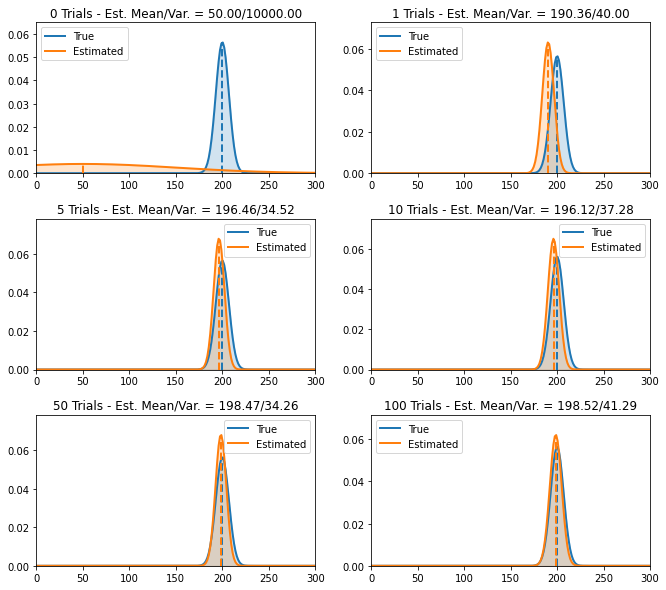

In [5]:
mean, variance = 200, 50 ## example 
cpc = UnknownMeanUnknownVariance( mean, variance )

draw_samples = [0, 1, 4, 5, 40, 50]
x = np.linspace(0.0,300.0,200)

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
    plt.subplot(3, 2, j+1)         
    plt.subplots_adjust(hspace = 0.3)
  
    for k in range(i):          
        reward = cpc.profit()
        cpc.update(reward)          

    title = f"{cpc.n} Trials - Est. Mean/Var. = {cpc.mu_0:0.2f}/{cpc.variance_0:.2f}"  
    plot_cpc( cpc, title = title )
    
# plt.savefig("Images/unknown_mean_unknown_variance.png",bbox_inches='tight') 

### Example simulation

In [6]:
profit_true_values = [60, 100, 80, 120, -10]
profit_variance = [20,15,30,10,46]

print(f"True Values = {profit_true_values}")
print(f"Variances = {profit_variance}")

True Values = [60, 100, 80, 120, -10]
Variances = [20, 15, 30, 10, 46]


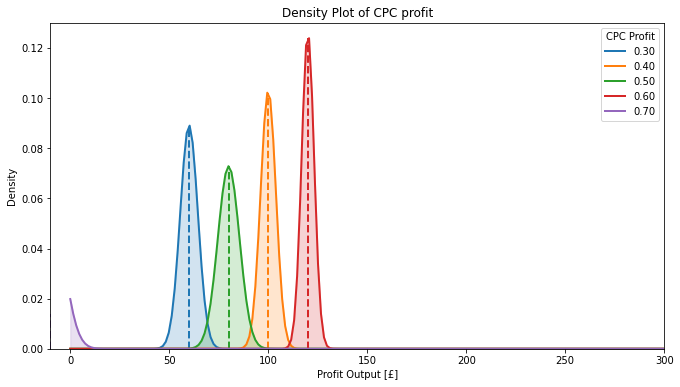

In [7]:
# create CPCs
cpcs = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(profit_true_values, profit_variance)]

figsize(11.0, 6)
plot_cpc_pdfs( cpcs )
# plt.savefig("Images/unknown_mean_unknown_variance_pdf.png",bbox_inches='tight') 

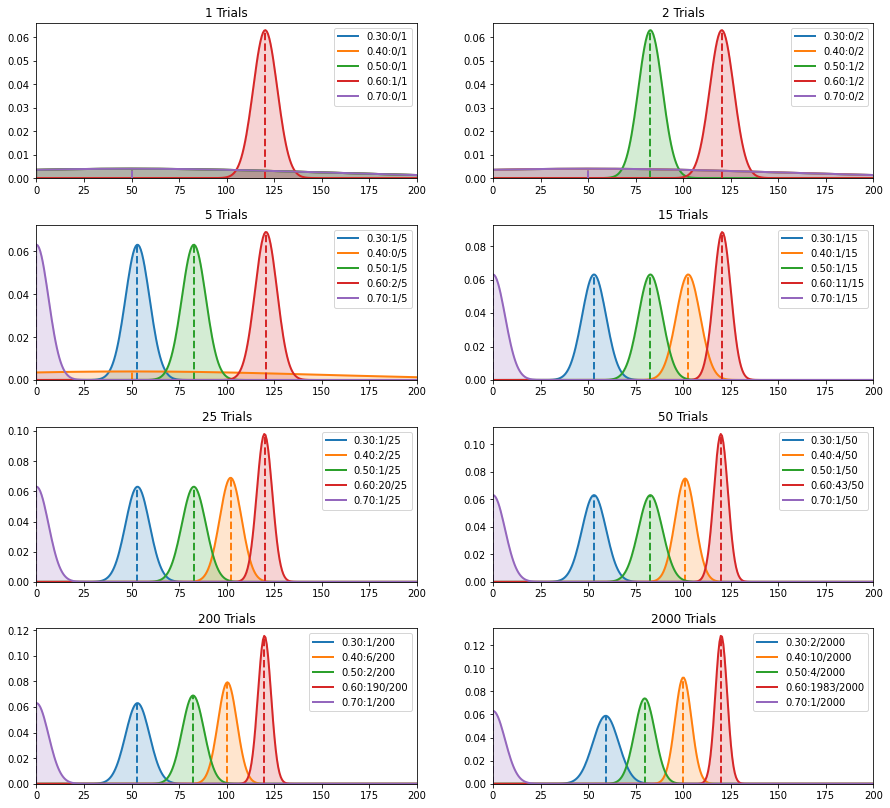

In [8]:
%matplotlib inline
cpcs = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(profit_true_values, profit_variance)]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 1800]
x = np.linspace(0.0,200.0,300)

figsize(15.0, 14)
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    plt.subplots_adjust(hspace = 0.3)
  
    for k in range(i):          
        # choose the cpc with the current highest sampled value or arbitrary select a cpc in the case of a tie            
        profit_samples = [cpc.sample() for cpc in cpcs]
        cpc_index = random_argmax(profit_samples)     

        # profit from the chosen cpc and update its mean reward value
        reward = cpcs[cpc_index].profit()
        cpcs[cpc_index].update(reward)          
  
    plot_cpcs(cpcs, profit_true_values)


For this simulation example, we can see that it takes about 50/100 trials to correctly determine the profit distributions

# Non-stationary Posterior
What if the optimal drifts? For example every week (every 7 days/iterations) the mean shifts by say £10.

For simplicitly, we will only consider one campaign and one CPC.

It is clear that we might struggle with a drifting mean. It seems like it overcompensates by increasing the estimated variance as apposed to shifting the estimated mean. 
The intuition is that the simulation has seen a lot of datapoints leaning towards 200 / 190 / 180 etc. It can take 1000s of new observations to forget what we have learnt so far.

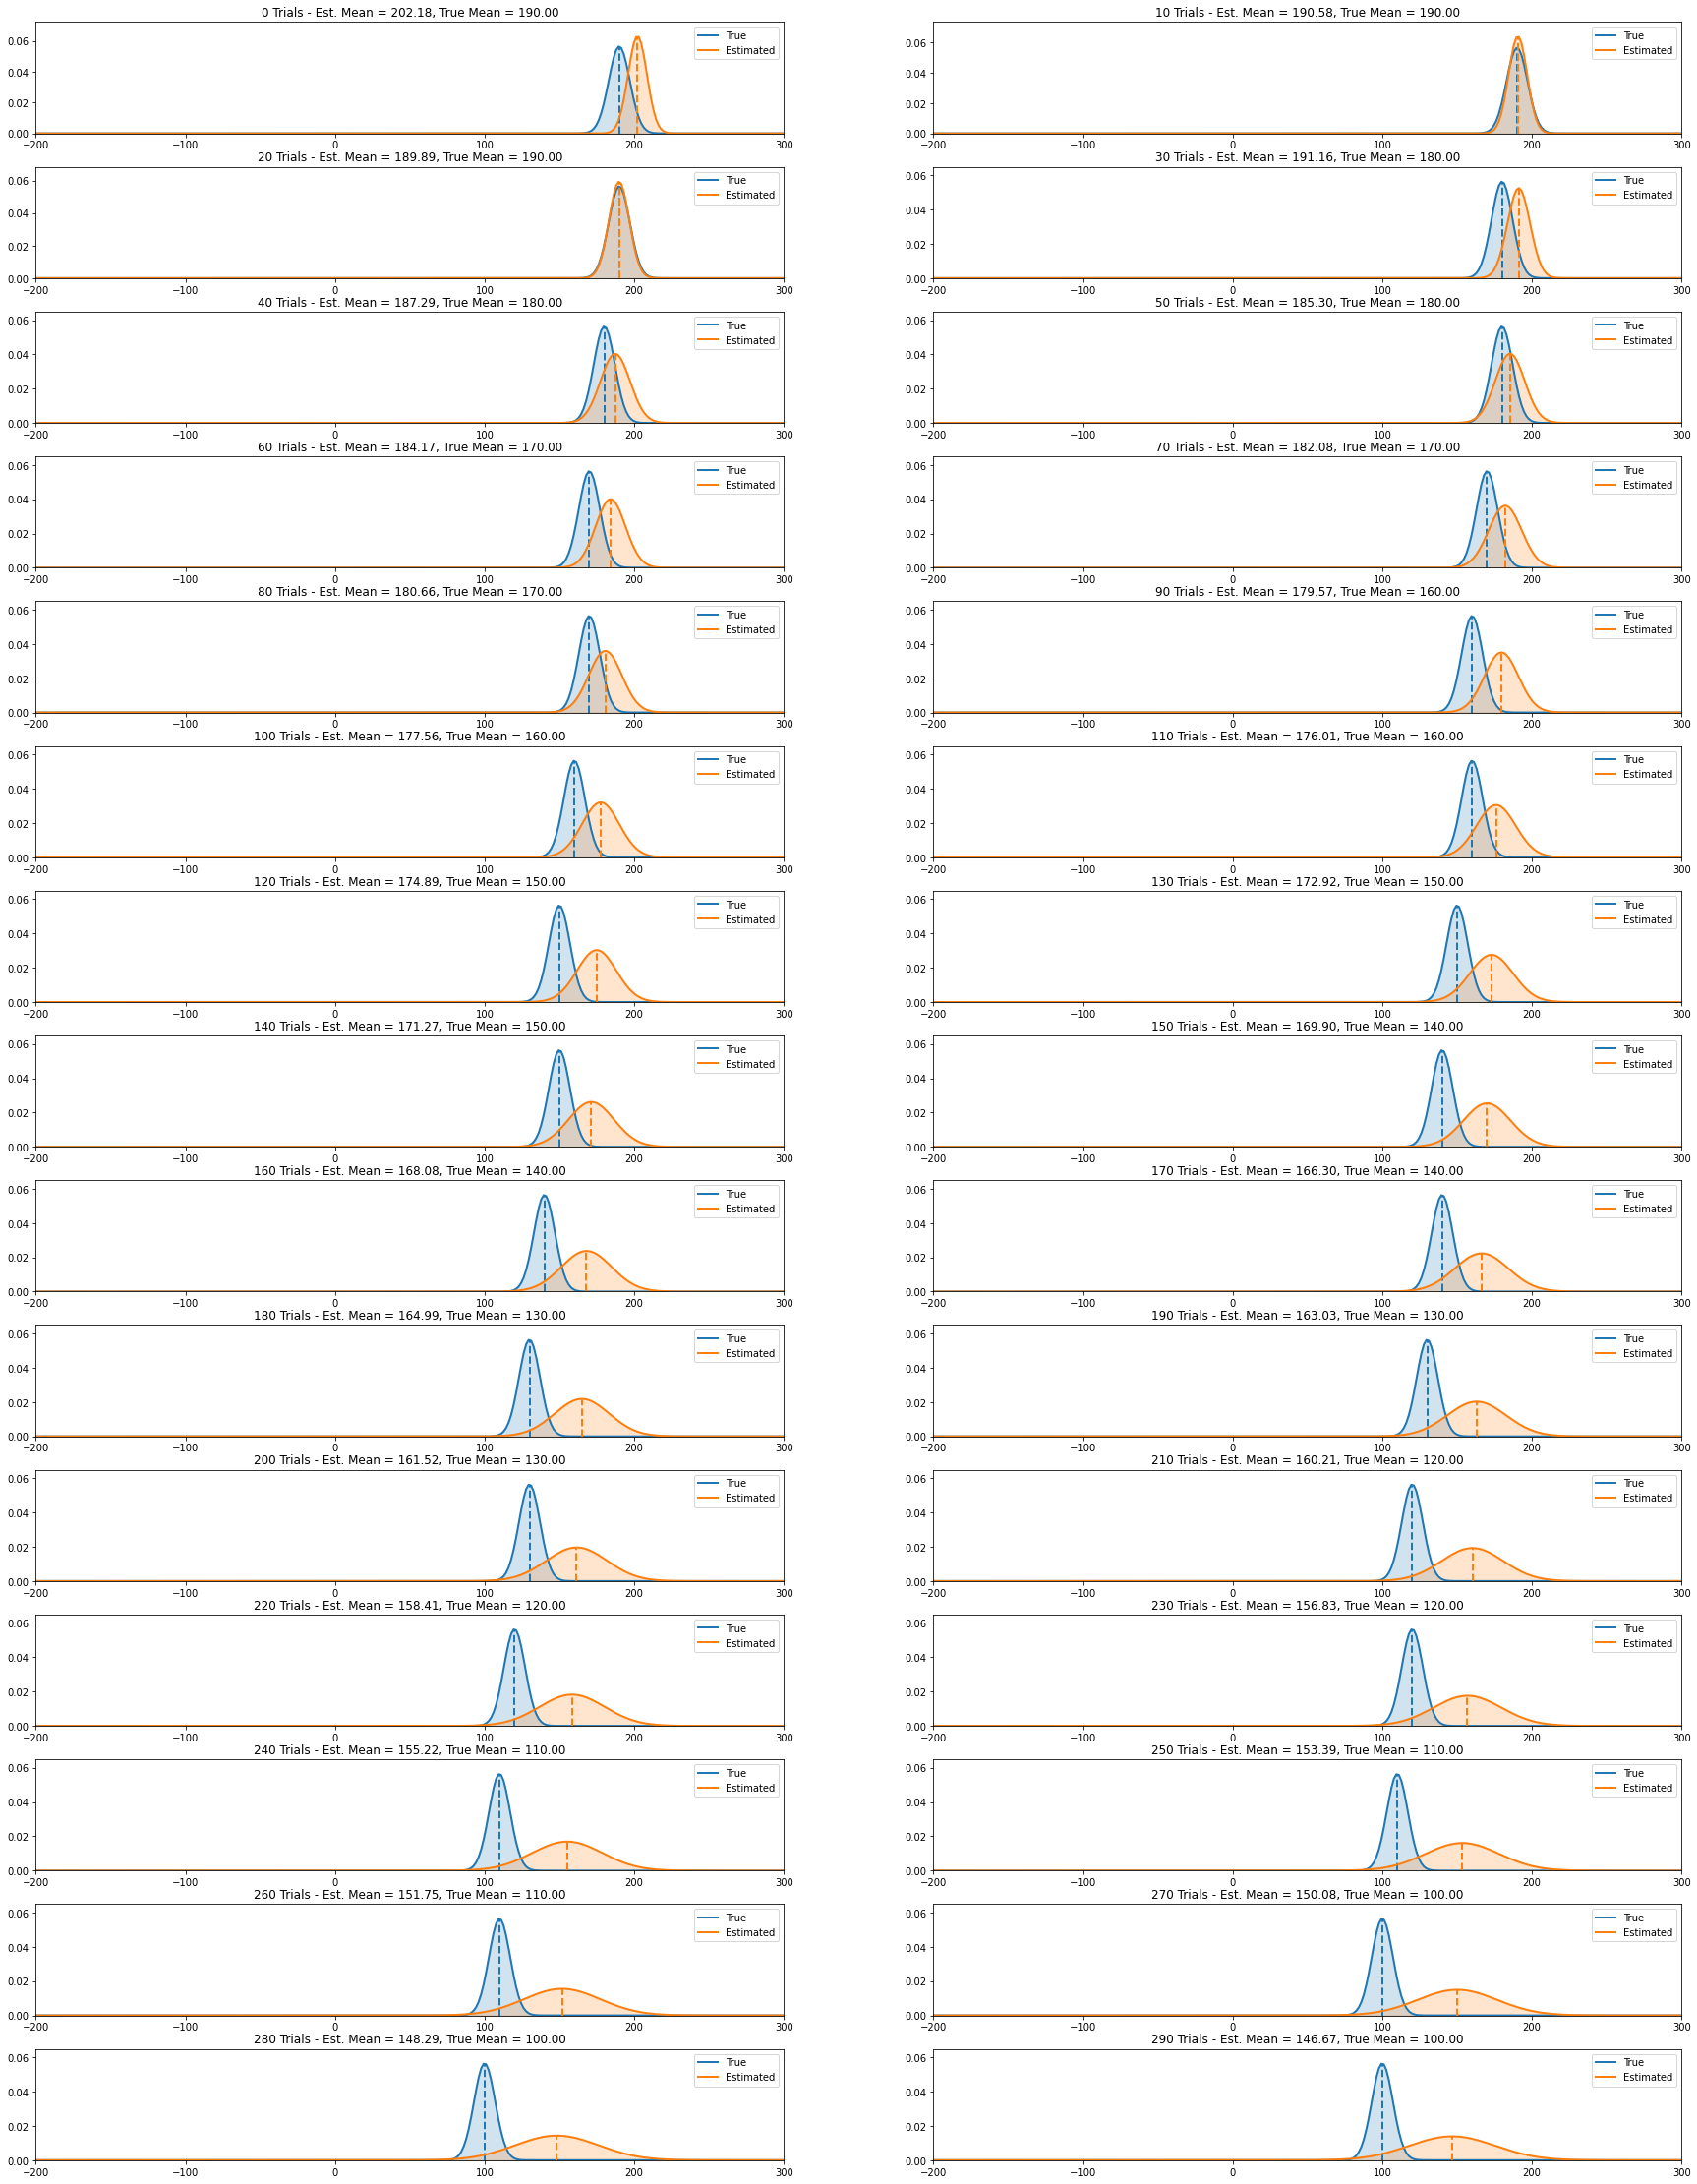

In [9]:
mean, variance = 200, 50 ## example 
cpc = UnknownMeanUnknownVariance( mean, variance )
figsize(30.0, 40)

interval = 30
total_intervals = 10
plot_interval = 10
x = np.linspace(-200.0,300.0,300)
rows = int((interval * total_intervals) / 2 / plot_interval) # rows for plot
count = 0

for i in range(interval*total_intervals):

    if i % interval == 0:
        cpc.mu -= 10 # update true mean of profit distribution

    reward = cpc.profit() # draw from true distribution, simulates 1 profit observation
    cpc.update(reward) # update posterior based on this observation
    
    if i % plot_interval == 0:
        plt.subplot(rows, 2, count+1)         
        plt.subplots_adjust(hspace = 0.3)
        title = f"{i} Trials - Est. Mean = {cpc.mu_0:0.2f}, True Mean = {cpc.mu:0.2f}"  
        plot_cpc( cpc, title = title )
        count+=1

## If the true posterior freezes, how long until it catches up?
Freeze at mu = 100 and variance = 50.
Freeze at last iteration from the simulation above. 

Note: run the cell before every time you run this cell

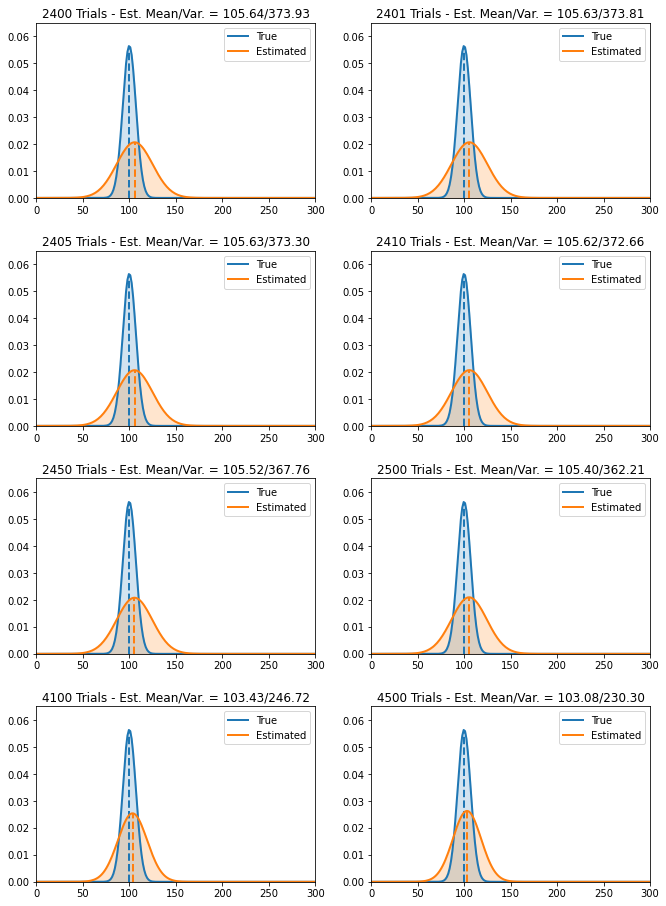

In [36]:
draw_samples = [0, 1, 4, 5, 40, 50, 1600, 400]
x = np.linspace(0.0,300.0,200)

figsize(11.0, 20)
for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)         
    plt.subplots_adjust(hspace = 0.3)
  
    for k in range(i):          
        reward = cpc.profit()
        cpc.update(reward)          

    title = f"{cpc.n} Trials - Est. Mean/Var. = {cpc.mu_0:0.2f}/{cpc.variance_0:.2f}"  
    plot_cpc( cpc, title = title )
    

## Idle CPC Variance Increase

When a CPC hasn't been selected in a long time, we would like it to have a chance to be selected again as behaviour might change. 

On solution to this problem could be to increase the variance over time of profit distributions for CPCs which arent being chosen. Increasing the variance will increase the chances of that CPC being selected. The intuition is that our confidence in that distribution decreases over time as we assume we are in a non-stationary regime, i.e the mean/variance of our posteriors might not be fixed. 

We start by using the stationary example to get the implementation working.

The example below scales the variance by the number of iterations (or days) that the CPC has been left idle. We will of course want to tune this as we do not want to over select bad options. We can potentially tune it by observing the frequency in which a CPC is selected. This can be once a month or week depending on how often we expect behaviour to change. In this example, the bad options are only chosen once every 1000 days. In practise, we might choose to have a bigger scale factor, this depends on the spread of profit values mostly. 

*** Result: Notice the number of times the bad CPC options are chosen in the legend. This is higher than it was before so they are all being selected more often ***

This does not fix the above issue but I have read in a few papers that this is a good thing to do to make sure we continually learn about all CPC options.

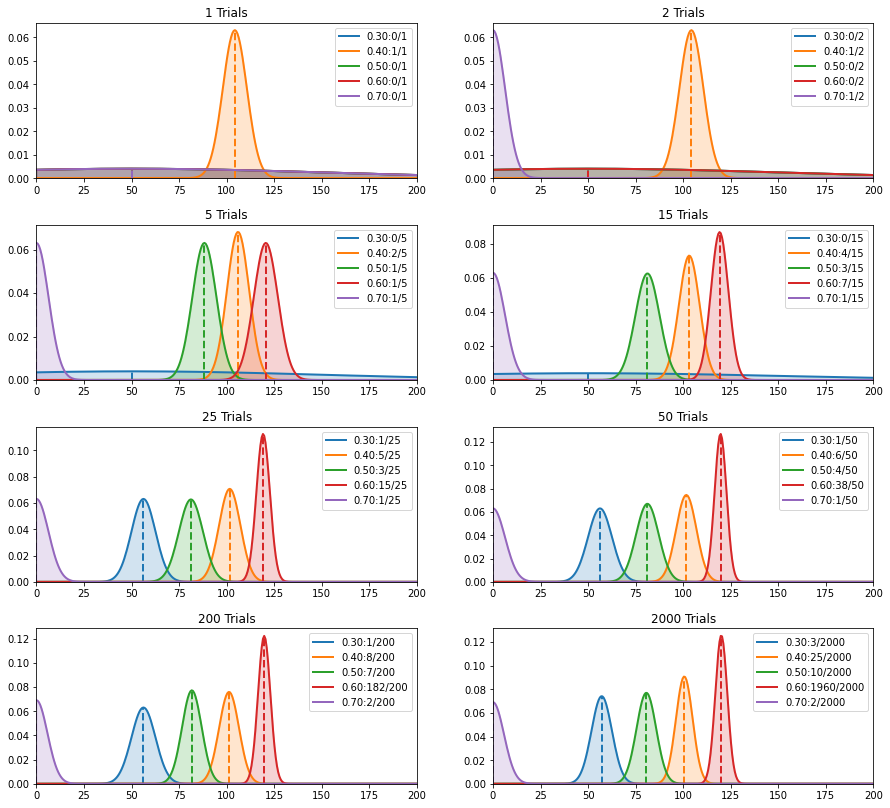

In [37]:
%matplotlib inline
cpcs = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(profit_true_values, profit_variance)]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 1800]
x = np.linspace(0.0,200.0,300)
cpc_idle_count = np.full(len(cpcs), 1) # this will keep track of how long a CPC is idle (scale factor)

figsize(15.0, 14)
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    plt.subplots_adjust(hspace = 0.3)
  
    for k in range(i):          
        
        # choose the cpc with the current highest sampled value or arbitrary select a cpc in the case of a tie 
        profit_samples = [cpcs[cpc].sample(idle_counts = cpc_idle_count[cpc]) for cpc in range(len(cpcs))]
        cpc_index = random_argmax(profit_samples) 
        # update idle count
        cpc_idle_count = [x+1 if x != cpc_index else 1 for x in range(len(cpcs))]
        # profit from the chosen cpc and update its mean reward value
        reward = cpcs[cpc_index].profit()
        cpcs[cpc_index].update(reward)          
  
    plot_cpcs(cpcs, profit_true_values)

In [21]:
cpc_idle_count

[1, 2, 3, 1, 5]